In [1]:
import eotdl

print(eotdl.__version__)


2025.04.22-3


In [2]:
import geopandas as gpd

gdf = gpd.read_parquet('fastdata/Satellogic/data/satellogic-earthview-items-with-matches.parquet')
gdf.head()


,json_path,zone,region,date,geometry,s1_matches,s2_matches
0,data/json/zone=30N/region=643316_556380/date=2...,30N,643316_556380,2022-10-12,"POLYGON ((-1.70376 5.02885, -1.70375 5.03232, ...",[{'id': 'S1A_IW_GRDH_1SDV_20221014T182630_2022...,[{'id': 'S2B_MSIL2A_20221013T101859_N0400_R065...
1,data/json/zone=40N/region=361450_2331678/date=...,40N,361450_2331678,2022-11-29,"POLYGON ((55.66997 21.07743, 55.66994 21.0809,...",[],[{'id': 'S2B_MSIL2A_20221129T065229_N0400_R020...
2,data/json/zone=11N/region=503028_3591876/date=...,11N,503028_3591876,2022-11-14,"POLYGON ((-116.96369 32.4606, -116.96369 32.46...",[{'id': 'S1A_IW_GRDH_1SDV_20221116T134454_2022...,[{'id': 'S2B_MSIL2A_20221116T182629_N0400_R127...
3,data/json/zone=42N/region=300244_2754317/date=...,42N,300244_2754317,2022-10-20,"POLYGON ((67.0263 24.88747, 67.02625 24.89094,...",[{'id': 'S1A_IW_GRDH_1SDV_20221017T012642_2022...,[{'id': 'S2A_MSIL2A_20221023T060921_N0400_R134...
4,data/json/zone=42N/region=571539_2523602/date=...,42N,571539_2523602,2022-09-01,"POLYGON ((69.70085 22.81506, 69.70087 22.81853...",[],[{'id': 'S2B_MSIL2A_20220902T054639_N0400_R048...


In [3]:
gdf.shape

(100, 7)

In [7]:
from find_matches import search_matches_by_sentinel
from eotdl.tools import bbox_from_centroid

sample =  gdf.sample(1)

# Prepare sample details
date = sample.date.iloc[0]
json_path = sample.json_path.iloc[0]
centroid = sample.geometry.iloc[0].centroid

_, s1_matches = search_matches_by_sentinel((_, date, centroid), collection_id="sentinel-1-grd")
_, s2_matches = search_matches_by_sentinel((_, date, centroid), collection_id="sentinel-2-l2a")

# todo: resample if no s1 matches or no s2 matches after cloud filter?

print(f"s1_matches: {s1_matches}\n")
print(f"s2_matches {s2_matches}\n")

s1_matches: [{'id': 'S1A_IW_GRDH_1SDV_20221001T143732_20221001T143757_045250_0568BF_641C', 'properties': {'datetime': '2022-10-01T14:37:32Z'}}, {'id': 'S1A_IW_GRDH_1SDV_20220930T025305_20220930T025330_045228_0567F2_2DFA', 'properties': {'datetime': '2022-09-30T02:53:05Z'}}, {'id': 'S1A_IW_GRDH_1SDV_20220925T024452_20220925T024517_045155_05658C_CB78', 'properties': {'datetime': '2022-09-25T02:44:52Z'}}]

s2_matches [{'id': 'S2A_MSIL2A_20220930T073721_N0400_R092_T39STD_20220930T112357', 'properties': {'datetime': '2022-09-30T07:49:01Z', 'eo:cloud_cover': 0.23}}, {'id': 'S2A_MSIL2A_20220930T073721_N0400_R092_T39SUD_20220930T112357', 'properties': {'datetime': '2022-09-30T07:48:56Z', 'eo:cloud_cover': 0.0}}, {'id': 'S2A_MSIL2A_20220927T072701_N0400_R049_T39STD_20220927T112002', 'properties': {'datetime': '2022-09-27T07:39:04Z', 'eo:cloud_cover': 0.14}}, {'id': 'S2A_MSIL2A_20220927T072701_N0400_R049_T39SUD_20220927T112002', 'properties': {'datetime': '2022-09-27T07:39:01Z', 'eo:cloud_cover'

In [8]:
import shutil
import os

from download_images import download_triplet_images

# Remove and recreate the sample folder structure
shutil.rmtree('sample', ignore_errors=True)
os.makedirs('sample/satellogic', exist_ok=True)
os.makedirs('sample/sentinel1', exist_ok=True)
os.makedirs('sample/sentinel2', exist_ok=True)

print("collecting...")

# Base name for all files
base_name = json_path.split('/')[-1].replace('_metadata.json', '')
satellogic_name = f"{base_name}_TOA.tif"
sent1_name = f"{base_name}_S1GRD.tiff"
sent2_name = f"{base_name}_S2L2A.tiff"

# Destination paths
dst_sat = f"sample/satellogic/{satellogic_name}"
dst_s1 = f"sample/sentinel1/{sent1_name}"
dst_s2 = f"sample/sentinel2/{sent2_name}"

# download s1, s2, and hr to /fastdata/data/tifs
download_triplet_images((s1_matches, s2_matches, date, json_path, centroid),
							output_dir="sample"
							)

print("✅ All files copied successfully.")
    

collecting...
s1_matches: ['S1A_IW_GRDH_1SDV_20221001T143732_20221001T143757_045250_0568BF_641C', 'S1A_IW_GRDH_1SDV_20220930T025305_20220930T025330_045228_0567F2_2DFA', 'S1A_IW_GRDH_1SDV_20220925T024452_20220925T024517_045155_05658C_CB78']
s2_matches: ['S2A_MSIL2A_20220930T073721_N0400_R092_T39SUD_20220930T112357']
Saving HR image to: sample/satellogic/20220928_101254_SN29_39N_300398_4367387_TOA.tif
Downloaded!
-------------------------
✅ All files copied successfully.


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


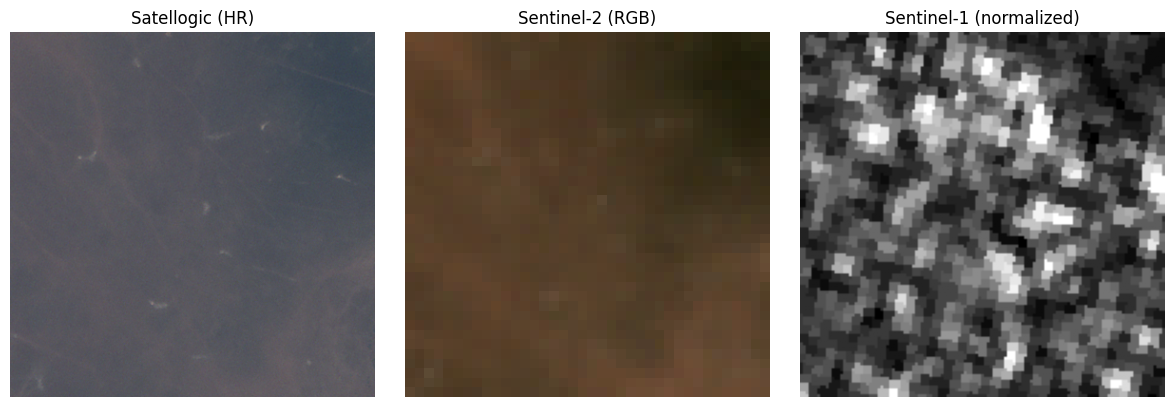

In [9]:
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Satellogic (HR)
axs[0].imshow((rio.open(dst_sat).read()[:3, ...].transpose(1, 2, 0) / 3000).clip(0, 1))
axs[0].set_title("Satellogic (HR)")
axs[0].axis('off')

if os.path.exists(dst_s2):
	# Sentinel-2 (RGB: bands 4, 3, 2)
	axs[1].imshow((rio.open(dst_s2).read()[(3, 2, 1), ...].transpose(1, 2, 0) / 3000).clip(0, 1))
axs[1].set_title("Sentinel-2 (RGB)")
axs[1].axis('off')

if os.path.exists(dst_s1):
	# Sentinel-1 (bands 3, 2, 1 if available; fallback to band 1 grayscale)
	with rio.open(dst_s1) as src:
		band = src.read(1).astype(np.float32)
	
		# Optional: remove very high outliers for better contrast
		band = np.clip(band, 0, np.percentile(band, 99))
	
		# Normalize to 0–1
		band = (band - band.min()) / (band.max() - band.min() + 1e-5)
	
	axs[2].imshow(band, cmap='gray')
axs[2].set_title("Sentinel-1 (normalized)")
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt


# plot histogram with number of images per zone
fig = plt.figure(figsize=(15, 3))
gdf['zone'].value_counts().plot(kind='bar', ax=fig.gca(), grid=True)
plt.show()


In [ ]:
len(gdf['zone'].unique()), len(gdf['region'].unique())

In [ ]:
gdf['zone'].value_counts().min()

In [ ]:
# plot histogram with number of images per month (all images are from 2022)
fig = plt.figure(figsize=(15, 3))
gdf['date'].dt.month.value_counts().plot(kind='bar', ax=fig.gca(), grid=True)
plt.show()


In [ ]:
zones = sorted(gdf['zone'].unique())
zone_gdf = gdf[gdf['zone'] == zones[4]]
n = min(5, len(zone_gdf))
sample = zone_gdf.sample(n, random_state=2025)
sample